In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [40]:
from src.qlearning import QLearningAgent
from src.utils import EpisodeStats
from envs.gridworld import GridworldEnv

import itertools
import numpy as np
import time

In [51]:
env_shape = (20, 20)
env = GridworldEnv(shape=env_shape)
num_episodes = 200
action_size = env.action_space.n
state_size = (env.observation_space.n, )

params = {
    "gamma": 0.5,
    "alpha": 1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.1,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}


In [47]:
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

q_agent = QLearningAgent(action_size=action_size, state_size=state_size, **params)

for episode in range(num_episodes):
    start = time.time()
    # Generate episode
    state = env.reset()
    state = (state, )
    for step in itertools.count():
        action = q_agent.policy(state)
        next_state, reward, done, _ = env.step(action)
        next_state = (next_state, )
        q_agent.update(state, next_state, action, reward)

        # Update statistics
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = step
        
        if done:
            q_agent.Q[next_state + (action, )] = 0
            break

        state = next_state
        
    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Time {:2f}".format(episode, num_episodes, stats.episode_rewards[episode], stats.episode_lengths[episode], time.time()-start))

Episode 0/200, Reward -1278.0, Total steps 1277.0, Time 0.049504
Episode 100/200, Reward -50.0, Total steps 49.0, Time 0.001527


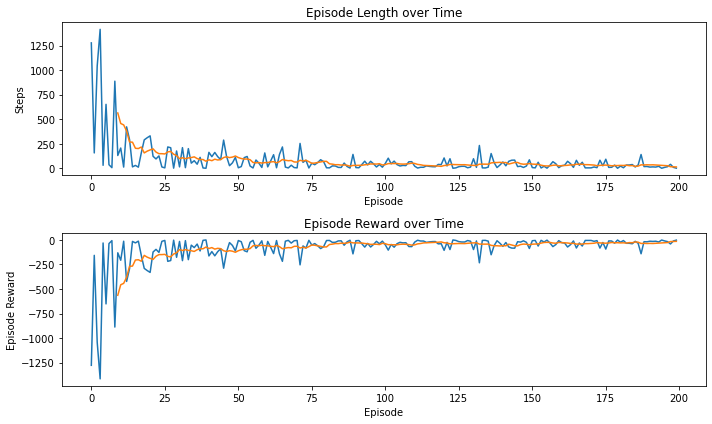

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(stats.episode_lengths)
rm = pd.Series(stats.episode_lengths).rolling(10).mean()
ax1.plot(rm)
ax1.set_xlabel("Episode")
ax1.set_ylabel("Steps")
ax1.set_title("Episode Length over Time")

ax2.plot(stats.episode_rewards)
rm = pd.Series(stats.episode_rewards).rolling(10).mean()
ax2.plot(rm)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Episode Reward")
ax2.set_title("Episode Reward over Time")
fig.tight_layout()

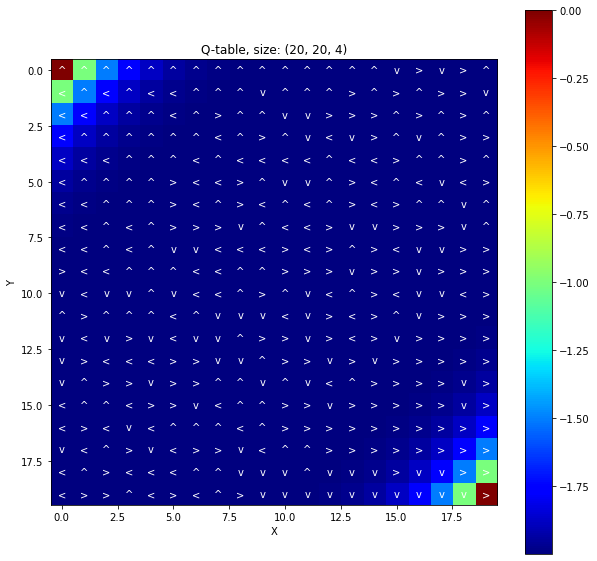

In [54]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    act_dict = {
        0:  "^",
        1: ">",
        2: "v",
        3: "<"
    }

    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, act_dict[q_actions[x, y]], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')


plot_q_table(np.reshape(q_agent.Q, env_shape + (action_size, )))